# Loading and Preparing List of URLs

In [28]:
## Getting the list of URLS from the official CSV 
## https://gitlab.com/recommend.games/bgg-ranking-historicals/-/tree/master?ref_type=heads

import pandas as pd

df = pd.read_csv('FullBGGData_2024-05-08.csv', sep=',', header=0)
df.head()

,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail
0,224517,Brass: Birmingham,2018,1,8.60,8.416,44997,/boardgame/224517/brass-birmingham,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...
1,161936,Pandemic Legacy: Season 1,2015,2,8.53,8.382,53188,/boardgame/161936/pandemic-legacy-season-1,https://cf.geekdo-images.com/-Qer2BBPG7qGGDu6K...
2,174430,Gloomhaven,2017,3,8.59,8.357,61809,/boardgame/174430/gloomhaven,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...
3,342942,Ark Nova,2021,4,8.54,8.333,42308,/boardgame/342942/ark-nova,https://cf.geekdo-images.com/SoU8p28Sk1s8MSvoM...
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.61,8.243,23460,/boardgame/233078/twilight-imperium-fourth-edi...,https://cf.geekdo-images.com/_Ppn5lssO5OaildSE...


In [29]:
baseurl = 'https://boardgamegeek.com'
listurls = df.URL.to_list()
listurls = [baseurl + url for url in listurls]
print(f'Number of URLs: {len(listurls)}')
print()
listurls[:3]

Number of URLs: 26286



['https://boardgamegeek.com/boardgame/224517/brass-birmingham',
 'https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1',
 'https://boardgamegeek.com/boardgame/174430/gloomhaven']

# Functions

In [30]:
import requests
import json
from bs4 import BeautifulSoup
import time
import pandas as pd  # Import the pandas library
import re

def fetch_page_content(url, headers={'User-Agent': 'Mozilla/5.0'}):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.content
    except requests.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return None

def parse_html(html_content):
    return BeautifulSoup(html_content, "html.parser")

def extract_game_data(soup, url, rank):
    game_data = {}
    objectid = url.split('/')[-2]

    title_tag = soup.find('title')
    title_text = title_tag.text.split('|')[0] if title_tag else 'Unknown'
    game_data['Title'] = title_text

    json_data_match = re.search(r'GEEK\.geekitemPreload = ({.*?});', str(soup))
    if json_data_match:
        try:
            json_data = json.loads(json_data_match.group(1))
            game_data['Link'] = url
            game_data['Rank'] = rank  # Store in dictionary 
            year_published = json_data.get('item', {}).get('yearpublished', 'Unknown')
            game_data['Year'] = year_published  # Store in dictionary        
            # Extract additional game info
            stats = json_data.get('item', {}).get('stats', {})
            game_data['UsersRated'] = stats.get('usersrated', 'Unknown')
            game_data['AveRating'] = stats.get('average', 'Unknown')
            game_data['Baverage'] = stats.get('baverage', 'Unknown')
            game_data['StdDev'] = stats.get('stddev', 'Unknown')
            game_data['AveWeight'] = stats.get('avgweight', 'Unknown')
            game_data['NumWeights'] = stats.get('numweights', 'Unknown')
            game_data['NumPlays'] = stats.get('numplays', 'Unknown')
            linkcounts = json_data.get('item', {}).get('linkcounts', {})
            game_data['NumAwards'] = linkcounts.get('boardgamehonor', 0)
            polls = json_data.get('item', {}).get('polls', {})
            game_data['PCountRecomm_min'] = polls.get('userplayers', 'Unknown')['recommended'][0]['min']
            game_data['PCountRecomm_max'] = polls.get('userplayers', 'Unknown')['recommended'][0]['max']
            game_data['PCountBest_min'] = polls.get('userplayers', 'Unknown')['best'][0]['min']
            game_data['PCountBest_max'] = polls.get('userplayers', 'Unknown')['best'][0]['max']
            game_data['PCount_votes'] = polls.get('userplayers', 'Unknown')['totalvotes']
            game_data['MinPlayTime'] = json_data.get('item', {}).get('minplaytime', 'NA')
            game_data['MaxPlayTime'] = json_data.get('item', {}).get('maxplaytime', 'NA')
            mechanics = json_data.get('item', {}).get('links', {}).get('boardgamemechanic', [])
            mechstring = ''
            for i, mech in enumerate(mechanics):
                mechstring += mech['name']
                if i < len(mech)-1:
                    mechstring += '\n'
            game_data['Mechanics'] = mechstring          
            rankinfo = json_data.get('item', {}).get('rankinfo', [])
            for i, rinf in enumerate(rankinfo):
                if rinf['prettyname'] != 'Board Game Rank':
                    game_data['GameCategory_'+str(i)] = rinf['veryshortprettyname']
                    game_data['RankCategory_'+str(i)] = rinf['rank']
                    game_data['ScoreCategory_'+str(i)] = rinf['baverage']          
            rank += 1
        except json.JSONDecodeError as e:
            print(f"JSONDecodeError: {e}")
    else:
        print("JSON data not found in HTML content.")

    # Amazon price extraction logic
    amazon_url = "https://api.geekdo.com/api/amazon/textads"
    params = {"locale": "us", "objectid": objectid, "objecttype": "thing"}
    response = requests.get(amazon_url, params=params)
    if response.status_code == 200:
        amazon_data = response.json()
        if isinstance(amazon_data, dict):  # Check if the response is a dictionary
            price = amazon_data.get('us', {}).get('newprice', 'Unknown')
        else:
            price = 'Unknown'
        game_data['AmazonPrice'] = price
    else:
        game_data['AmazonPrice'] = 'Unknown'

    return game_data

def scrape_boardgame_data(url, games_data_df=pd.DataFrame(), headers={'User-Agent': 'Mozilla/5.0'}, rank=1):
    html_content = fetch_page_content(url, headers)
    if html_content:
        soup = parse_html(html_content)
        game_data = extract_game_data(soup, url, rank)
        if game_data:
            series = pd.DataFrame([game_data])
            games_data_df = pd.concat([games_data_df, series], ignore_index=True)
        return games_data_df
    else:
        print(f"Error fetching URL {url}")
        return games_data_df

# Actually scrapping the data

In [31]:
num_urls_subset = 5000

rank = 1
games_data_df = pd.DataFrame()
for url in listurls[:num_urls_subset]:
    games_data_df = scrape_boardgame_data(url, games_data_df, rank=rank)
    rank += 1

games_data_df.head()

KeyboardInterrupt: 

## ... Continuation?

Sometimes the scrapping crashes due to connection problems.

In [26]:
lasturl = games_data_df['Link'].iloc[-1]

initialize = False
for url in listurls[:num_urls_subset]:
    if url == lasturl:
        initialize = True
        continue    
    if initialize:
        games_data_df = scrape_boardgame_data(url, games_data_df, rank=rank)
        rank += 1

In [27]:
games_data_df

,Title,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,...,MinPlayTime,MaxPlayTime,Mechanics,GameCategory_1,RankCategory_1,ScoreCategory_1,AmazonPrice,GameCategory_2,RankCategory_2,ScoreCategory_2
0,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,46043,8.59731,8.41456,1.41606,3.8789,2229,...,60,120,Hand Management\nIncome\nLoans\nMarket\nNetwor...,Strategy,1,8.43113,$63.48,NaN,NaN,NaN
1,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,53558,8.52713,8.37875,1.5984,2.8316,1461,...,60,60,Action Points\nCooperative Game\nHand Manageme...,Thematic,1,8.37923,$71.97,Strategy,2,8.3668
2,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,3,2017,62246,8.58836,8.35218,1.73928,3.9115,2566,...,60,120,Action Queue\nAction Retrieval\nCampaign / Bat...,Thematic,2,8.33121,$285.49,Strategy,4,8.31405
3,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,4,2021,43695,8.53514,8.33503,1.38399,3.7606,2297,...,90,150,Action Queue\nEnd Game Bonuses\nGrid Coverage\...,Strategy,3,8.3448,$56.92,NaN,NaN,NaN
4,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,23849,8.60087,8.24171,1.62048,4.319,1166,...,240,480,Action Drafting\nArea-Impulse\nDice Rolling\nF...,Thematic,3,8.26231,$131.99,Strategy,5,8.26381
5,Dune: Imperium,https://boardgamegeek.com/boardgame/316554/dun...,6,2020,45614,8.43546,8.23065,1.27194,3.0483,1616,...,60,120,"Card Play Conflict Resolution\nDeck, Bag, and ...",Strategy,6,8.23235,$51.35,NaN,NaN,NaN
6,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,7,2016,99208,8.35948,8.21267,1.42039,3.2612,4115,...,120,120,Closed Drafting\nContracts\nEnclosure\nEnd Gam...,Strategy,7,8.19006,$57.85,NaN,NaN,NaN
7,War of the Ring: Second Edition,https://boardgamegeek.com/boardgame/115746/war...,8,2011,21397,8.54215,8.18653,1.47406,4.2147,1183,...,150,180,Action Drafting\nArea Majority / Influence\nAr...,War,1,8.28563,$71.68,Thematic,4,8.24584
8,Star Wars: Rebellion,https://boardgamegeek.com/boardgame/187645/sta...,9,2016,32502,8.41979,8.17126,1.36406,3.7454,1135,...,180,240,Area Majority / Influence\nArea Movement\nArea...,Thematic,5,8.20703,$87.99,NaN,NaN,NaN
9,Gloomhaven: Jaws of the Lion,https://boardgamegeek.com/boardgame/291457/glo...,10,2020,34361,8.43896,8.16457,1.46561,3.6408,994,...,30,120,Action Queue\nAction Retrieval\nCampaign / Bat...,Thematic,7,8.17441,$39.97,Strategy,9,8.14174


## Saving to a pickle file

In [9]:
name = f'bgg_data_0-{num_urls_subset}.pkl'
print('Name of pickle file:')
print(name)

results.to_pickle(name)

Name of pickle file:
bgg_data_0-20.pkl


## Loading Pickle file

In [131]:
import pandas as pd

results = pd.read_pickle('bgg_data_0-3313.pkl')
results.head()

,Title,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,...,Category_1,RankCat_1,ScoreCat_1,AmazonPrice,Category_2,RankCat_2,ScoreCat_2,Category_3,RankCat_3,ScoreCat_3
0,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,46043,8.59731,8.41456,1.41606,3.8789,2229,...,Strategy,1,8.43113,$63.48,NaN,NaN,NaN,NaN,NaN,NaN
1,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,53558,8.52713,8.37875,1.5984,2.8316,1461,...,Thematic,1,8.37923,$71.97,Strategy,2,8.3668,NaN,NaN,NaN
2,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,3,2017,62246,8.58836,8.35218,1.73928,3.9115,2566,...,Thematic,2,8.33121,$285.49,Strategy,4,8.31405,NaN,NaN,NaN
3,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,4,2021,43695,8.53514,8.33503,1.38399,3.7606,2297,...,Strategy,3,8.3448,$56.92,NaN,NaN,NaN,NaN,NaN,NaN
4,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,23849,8.60087,8.24171,1.62048,4.319,1166,...,Thematic,3,8.26231,$131.99,Strategy,5,8.26381,NaN,NaN,NaN


# Predicting the Price in Amazon with the Features from BBG

In [132]:
(results.loc[:, ['Title', 'Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage', 
                'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards', 
                'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes',
                'MinPlayTime', 'MaxPlayTime', 'Category_1', 'AmazonPrice']]
    .head()
)

,Title,Rank,Year,UsersRated,AveRating,Baverage,AveWeight,NumWeights,NumPlays,NumAwards,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,Category_1,AmazonPrice
0,Brass: Birmingham,1,2018,46043,8.59731,8.41456,3.8789,2229,124812,20,2,4.0,3,4.0,1106,60,120,Strategy,$63.48
1,Pandemic Legacy: Season 1,2,2015,53558,8.52713,8.37875,2.8316,1461,287053,30,2,4.0,4,4.0,863,60,60,Thematic,$71.97
2,Gloomhaven,3,2017,62246,8.58836,8.35218,3.9115,2566,513581,30,1,4.0,3,3.0,1542,60,120,Thematic,$285.49
3,Ark Nova,4,2021,43695,8.53514,8.33503,3.7606,2297,342465,36,1,3.0,2,2.0,1762,90,150,Strategy,$56.92
4,Twilight Imperium: Fourth Edition,5,2017,23849,8.60087,8.24171,4.319,1166,41631,2,3,6.0,6,6.0,572,240,480,Thematic,$131.99


In [133]:
# remove space (' ') if its the last character in the string
results['Category_1'] = results['Category_1'].apply(lambda x: x[:-1] if (isinstance(x, str) and x.endswith(' ')) else x)
# change "'" inside the string to avoid SQL errors
results['Title'] = results['Title'].apply(lambda x: x.replace("'", "") if isinstance(x, str) else x)
results['Category_1'] = results['Category_1'].apply(lambda x: x.replace("'", "") if isinstance(x, str) else x)
# If Catergory_1 is NaN, set it to 'Uncategorized'
results['Category_1'] = results['Category_1'].apply(lambda x: 'Uncategorized' if x != x else x)
results['Category_1'] = results['Category_1'].apply(lambda x: 'Uncategorized' if x == None else x)
# Remove $ sign from AmazonPrice
results['AmazonPrice'] = results['AmazonPrice'].apply(lambda x: x.replace('$', '') if isinstance(x, str) else x)
# if not Unknown in AmazonPrice, convert to float
results['AmazonPrice'] = results['AmazonPrice'].apply(lambda x: float(x) if x != 'Unknown' else x)
# if not Unknown in Year, convert to int
results['Year'] = results['Year'].apply(lambda x: int(x) if x != 'Unknown' else x)
# These columns should contain integers: UsersRated, NumWeights, NumPlays, NumAwards, PCountRecomm_min, PCountRecomm_max, PCountBest_min, PCountBest_max, PCount_votes, MinPlayTime, MaxPlayTime
results['UsersRated'] = results['UsersRated'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumWeights'] = results['NumWeights'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumPlays'] = results['NumPlays'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumAwards'] = results['NumAwards'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountRecomm_min'] = results['PCountRecomm_min'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountRecomm_max'] = results['PCountRecomm_max'].fillna(results['PCountRecomm_min'])
results['PCountRecomm_max'] = results['PCountRecomm_max'].apply(lambda x: int(x) if x != 'Unknown' else x)
# If PCountRecomm_max == nan then set it to PCountRecomm_min
results['PCountBest_min'] = results['PCountBest_min'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountBest_max'] = results['PCountBest_max'].fillna(results['PCountBest_min'])
results['PCountBest_max'] = results['PCountBest_max'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCount_votes'] = results['PCount_votes'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['MinPlayTime'] = results['MinPlayTime'].apply(lambda x: int(x) if x != 'NA' else x)
results['MaxPlayTime'] = results['MaxPlayTime'].apply(lambda x: int(x) if x != 'NA' else x)
# These columns should contain floats: AveRating, Baverage, StdDev, AveWeight
results['AveRating'] = results['AveRating'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['Baverage'] = results['Baverage'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['StdDev'] = results['StdDev'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['AveWeight'] = results['AveWeight'].apply(lambda x: float(x) if x != 'Unknown' else x)

In [134]:
# These columns will not be used for the model
results.drop(['RankCat_1', 'ScoreCat_1', 'Category_2', 'RankCat_2', 'ScoreCat_2', 'Category_3', 'RankCat_3', 'ScoreCat_3'], axis=1, inplace=True)

In [135]:
(results[results.isnull().any(axis=1)]
#    .Link
    .T
 )

""
Title
Link
Rank
Year
UsersRated
AveRating
Baverage
StdDev
AveWeight
NumWeights


In [136]:
results['Category_1'] = results['Category_1'].astype('category')

In [137]:
results.dtypes

Title                 object
Link                  object
Rank                   int64
Year                   int64
UsersRated             int64
AveRating            float64
Baverage             float64
StdDev               float64
AveWeight            float64
NumWeights             int64
NumPlays               int64
NumAwards              int64
PCountRecomm_min       int64
PCountRecomm_max       int64
PCountBest_min         int64
PCountBest_max         int64
PCount_votes           int64
MinPlayTime            int64
MaxPlayTime            int64
Mechanics             object
Category_1          category
AmazonPrice           object
dtype: object

In [138]:
(results
    .query('AmazonPrice != "Unknown"')
)

,Title,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,...,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,Mechanics,Category_1,AmazonPrice
0,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,46043,8.59731,8.41456,1.41606,3.8789,2229,...,2,4,3,4,1106,60,120,Hand Management\nIncome\nLoans\nMarket\nNetwor...,Strategy,63.48
1,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,53558,8.52713,8.37875,1.59840,2.8316,1461,...,2,4,4,4,863,60,60,Action Points\nCooperative Game\nHand Manageme...,Thematic,71.97
2,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,3,2017,62246,8.58836,8.35218,1.73928,3.9115,2566,...,1,4,3,3,1542,60,120,Action Queue\nAction Retrieval\nCampaign / Bat...,Thematic,285.49
3,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,4,2021,43695,8.53514,8.33503,1.38399,3.7606,2297,...,1,3,2,2,1762,90,150,Action Queue\nEnd Game Bonuses\nGrid Coverage\...,Strategy,56.92
4,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,23849,8.60087,8.24171,1.62048,4.3190,1166,...,3,6,6,6,572,240,480,Action Drafting\nArea-Impulse\nDice Rolling\nF...,Thematic,131.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,Sequence,https://boardgamegeek.com/boardgame/2375/sequence,3302,1982,10556,6.12146,5.93070,1.49566,1.3147,502,...,2,4,3,4,107,10,30,Hand Management\nPattern Building\nTake That\n...,Family,14.97
3305,Valparaíso,https://boardgamegeek.com/boardgame/257058/val...,3306,2018,952,6.87959,5.92737,1.12636,2.8049,41,...,2,5,5,5,25,45,90,Action Queue\nKill Steal\nPoint to Point Movem...,Strategy,48.95
3307,Dungeons & Dragons: Rock Paper Wizard,https://boardgamegeek.com/boardgame/207062/dun...,3308,2016,1530,6.57288,5.93244,1.36025,1.3333,27,...,3,6,5,6,17,30,30,Simultaneous Action Selection\nTake That\n,Party,21.72
3310,The Blood of an Englishman,https://boardgamegeek.com/boardgame/206504/blo...,3311,2016,1496,6.54979,5.92681,1.23373,1.8261,23,...,2,2,2,2,10,20,30,Pattern Building\nVariable Player Powers\n,Family,16.19


In [155]:
data = (
    results
        .loc[:, ['Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage', 
                'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards', 
                'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes',
                'MinPlayTime', 'MaxPlayTime', 'Category_1', 'AmazonPrice']]
        .query('AmazonPrice != "Unknown"')
        .query('AmazonPrice < 200')
        .copy()
)

In [156]:
data.AmazonPrice.describe()

count     1695.00
unique     982.00
top         39.99
freq        31.00
Name: AmazonPrice, dtype: float64

In [160]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = data.columns[1:-1]

X = data[features]
y = data['AmazonPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBRegressor(objective='reg:squarederror', 
                     enable_categorical=True,
                     verbosity=0,
                     n_estimators=1000,
                     max_depth=10,
                     learning_rate=0.1,
                     subsample=0.9,
                     colsample_bytree=0.9,
                     reg_lambda=1,
                     reg_alpha=0,
                     gamma=0,
                     min_child_weight=1,)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [163]:
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R^2: {model.score(X_test, y_test):.2f}')

Mean Squared Error: 937.38
Mean Absolute Error: 20.68
R^2: 0.30


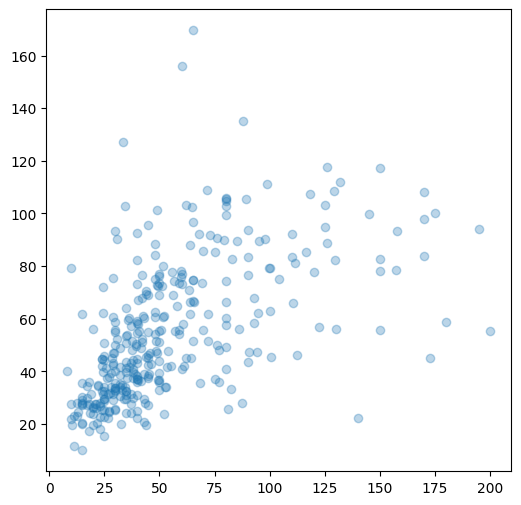

In [165]:
# plot true vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)